<a href="https://colab.research.google.com/github/sh-biswas/demand-forecasting_Cogs109Final/blob/master/Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# libraries that we need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (20, 10)
%matplotlib inline

In [2]:
# read in data
data = 'https://raw.githubusercontent.com/sh-biswas/demand-forecasting_Cogs109Final/master/train.csv'
data = pd.read_csv(data)

Check if there are any null values to watch out for in the dataset.

In [3]:
data.isnull().sum()

date     0
store    0
item     0
sales    0
dtype: int64

How many stores are there the dataset?

In [4]:
num_stores = len(data.store.unique())
print(num_stores)

10


How many different items in the dataset?

In [5]:
num_items = len(data.item.unique())
print(num_items)

50


In [6]:
# grab only most popular item
data = data[data['item'] == 15].reset_index(drop=True)

In [7]:
# parse date into "year", "month", and "day" columns

# create arrays to hold parsed year, month, and day
years = np.empty(data.shape[0]).astype('int32')
months = np.empty(data.shape[0]).astype('int32')
days = np.empty(data.shape[0]).astype('int32')
#print(f"len(years): {len(years)}")

# date_parser function
def date_parser(row):
  #print(f"row: \n{row}")
  #print(f"row['date']: {row['date']}")
  year, month, day = row['date'].split("-")
  #print(f"year: {year} | month: {month} | day: {day}")
  #print(f"row.name: {row.name}")
  years[row.name] = int(year); months[row.name] = int(month); days[row.name] = int(day);
  #print(years[row.name])

# call parser on all rows
data.apply(date_parser, axis=1)

# add "year", "month", and "day" columns to data
data['year'] = years
data['month'] = months
data['day'] = days

# sort by date
data = data.sort_values(by = ['date']).reset_index(drop=True)

In [8]:
# add in day of the week index for later
day_of_week = (np.arange(len(data)) + 10) % 70
day_of_week = day_of_week // 10
#day_of_week = [int(str(day)[0]) if len(str(day)) == 2 else 0 for day in day_of_week]
data['day_of_week'] = day_of_week
# 0 = Mon, 1 = Tues, 2 = Wed, 3 = Thurs, 4 = Fri, 5 = Sat, 6 = Sun

# add in day of the year index for later (leap years unnacounted for since shift will be tiny enough to not really matter)
day_of_year = np.arange(len(data)) % 3650
day_of_year = day_of_year // 10
data['day_of_year'] = day_of_year
# 0 = 01/01, 1 = 01/02, 2 = 01/03, ...

# add in year index
data['year_index'] = data['year'].values - 2013
# 0 = 2013, 1 = 2014, ... 
data

,date,store,item,sales,year,month,day,day_of_week,day_of_year,year_index
0,2013-01-01,1,15,42,2013,1,1,1,0,0
1,2013-01-01,6,15,38,2013,1,1,1,0,0
2,2013-01-01,4,15,46,2013,1,1,1,0,0
3,2013-01-01,7,15,27,2013,1,1,1,0,0
4,2013-01-01,3,15,61,2013,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...
18255,2017-12-31,3,15,104,2017,12,31,6,0,4
18256,2017-12-31,2,15,106,2017,12,31,6,0,4
18257,2017-12-31,1,15,64,2017,12,31,6,0,4
18258,2017-12-31,9,15,77,2017,12,31,6,0,4


In [9]:
# separate out train and test data
num_test_days = 365
train = data[:-num_test_days * num_stores]
test = data[-num_test_days * num_stores:]
print(f"first train date: {train.date[0]}")
print(f"length of train: {len(train)}")
print(f"number of train dates: {len(train['date'].unique())}")
print(f"first test date: {test.iloc[0].date}")
print(f"length of test: {len(test)}")
print(f"number of test datapoints dates: {len(test['date'].unique())}")

first train date: 2013-01-01
length of train: 14610
number of train dates: 1461
first test date: 2017-01-01
length of test: 3650
number of test datapoints dates: 365


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match D

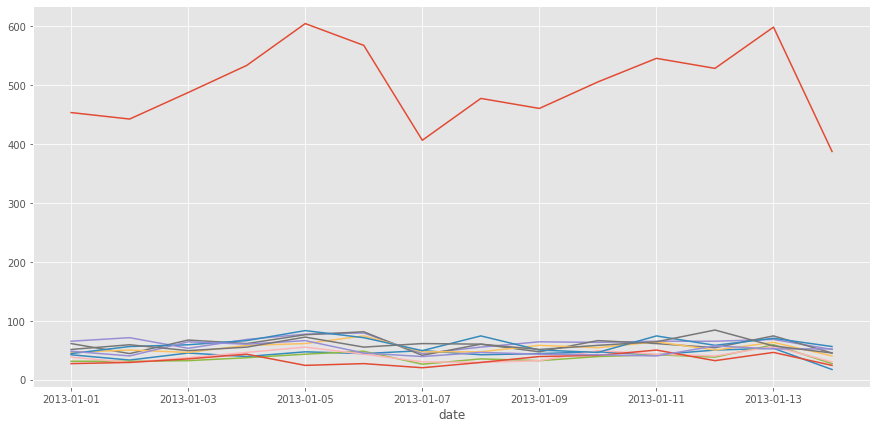

In [10]:
#example plotting of indiviudal store sales for item 15
fig, ax = plt.subplots(figsize=(15,7))
train[:140].groupby('date').sum()['sales'].plot(x='date', y='sales', ax=ax)
for i in np.arange(1, 11):
  train[:140][ (train['store'] == i) ].groupby('date').sum()['sales'].plot(x='date', y='sales', ax=ax)

# Research Question: What are the predicted sales for the most popular item bought from the supplier by the stores for the next 3 months?

### As a first step, let's look at a 1st-order model for just store 1.

In [11]:
# just for store 1 to start
train_store1 = train[ train['store'] == 1]
test_store1 = test[ test['store'] == 1]


# let's do some linear regression!
A = np.vstack((np.ones(len(train_store1)), train_store1['year'], train_store1['month'], train_store1['day'])).T
w = np.linalg.lstsq(A, train_store1['sales'], rcond=None)[0]
print(f"1st order model: {w[0]:0.2f} + {w[1]:0.2f}*year + {w[2]:0.2f}*month + {w[3]:0.2f}*day")

1st order model: -12980.74 + 6.48*year + 0.96*month + 0.00*day


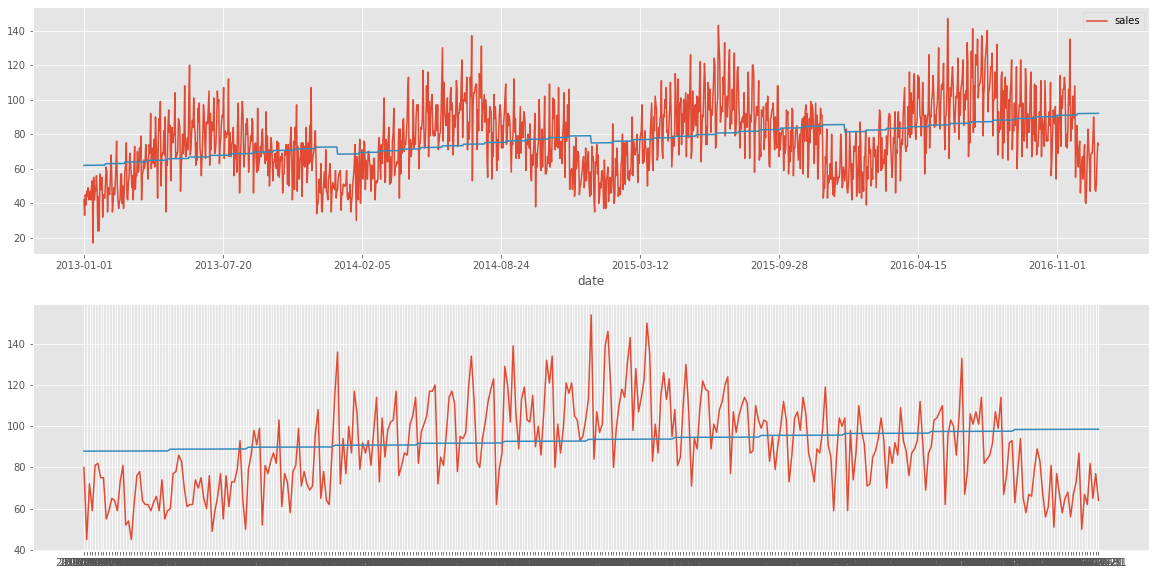

In [12]:
fig, axs = plt.subplots(2,1)
train_store1.plot(x='date', y='sales', figsize=(20,10), ax=axs[0])
axs[1].plot(test_store1['date'].values, test_store1['sales'].values)

## Create a smooth set of Y values for plotting the model
modelYtest = w[0] + w[1]*test_store1['year'].values + w[2]*test_store1['month'].values + w[3]*test_store1['day'].values
modelYtrain = w[0] + w[1]*train_store1['year'].values + w[2]*train_store1['month'].values + w[3]*train_store1['day'].values
axs[1].plot(test_store1['date'].values, modelYtest)
axs[0].plot(train_store1['date'].values, modelYtrain)
fig.show()

Model each item individually for all the stores -> supplier knows how many of each item to distribute over the time span of the test data(supplier perspective)

### First Order Model for All the Stores for Item 15.

In [13]:
# let's do some linear regression!
A = np.vstack((np.ones(len(train)), train['year'], train['month'], train['day'])).T
w = np.linalg.lstsq(A, train['sales'], rcond=None)[0]
print(f"1st order model: {w[0]:0.2f} + {w[1]:0.2f}*year + {w[2]:0.2f}*month + {w[3]:0.2f}*day")

1st order model: -13960.18 + 6.97*year + 1.16*month + 0.01*day


MSE_train: 732.9815593812714 | MSE_test: 957.6390202278587


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,date,store,item,sales,year,month,day,day_of_week,day_of_year,year_index,1st-order model
14610,2017-01-01,1,15,80,2017,1,1,6,1,4,96.138335
14611,2017-01-01,5,15,53,2017,1,1,6,1,4,96.138335
14612,2017-01-01,6,15,57,2017,1,1,6,1,4,96.138335
14613,2017-01-01,4,15,70,2017,1,1,6,1,4,96.138335
14614,2017-01-01,9,15,96,2017,1,1,6,1,4,96.138335
...,...,...,...,...,...,...,...,...,...,...,...
18255,2017-12-31,3,15,104,2017,12,31,6,0,4,109.190658
18256,2017-12-31,2,15,106,2017,12,31,6,0,4,109.190658
18257,2017-12-31,1,15,64,2017,12,31,6,0,4,109.190658
18258,2017-12-31,9,15,77,2017,12,31,6,0,4,109.190658


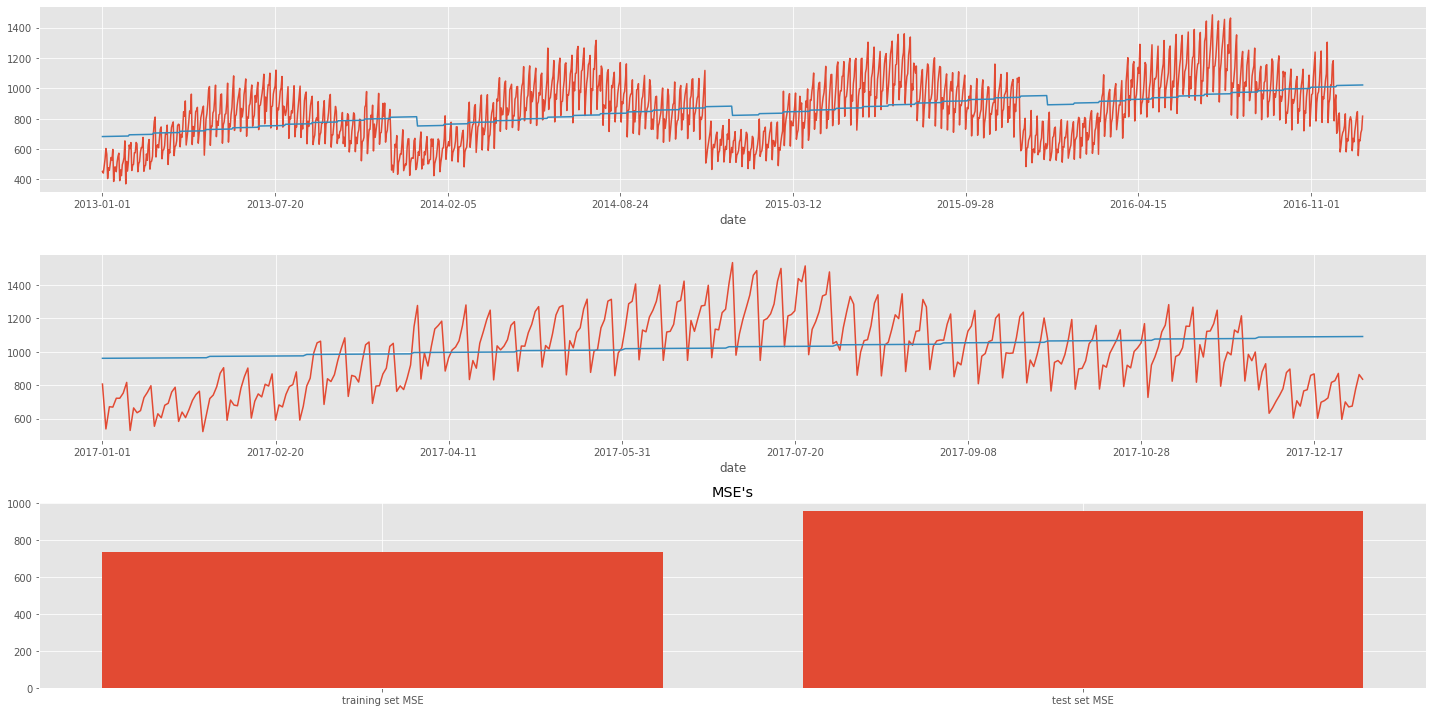

In [14]:
# plot the data
fig, axs = plt.subplots(3,1, figsize=(20,10))
train.groupby('date').sum()['sales'].plot(x='date', y='sales', ax=axs[0])
test.groupby('date').sum()['sales'].plot(x='date', y='sales', ax=axs[1])

## plot the model over data
#agg_train = train.groupby('date').sum(); agg_test = train.groupby('date').sum()
modelYtrain = w[0] + w[1]*train['year'].values + w[2]*train['month'].values + w[3]*train['day'].values
modelYtest = w[0] + w[1]*test['year'].values + w[2]*test['month'].values + w[3]*test['day'].values
train['1st-order model'] = modelYtrain; test['1st-order model'] = modelYtest;
train.groupby('date').sum()['1st-order model'].plot(x='date', y='1st-order model', ax=axs[0])
test.groupby('date').sum()['1st-order model'].plot(x='date', y='1st-order model', ax=axs[1])
#ax[0].plot(train['date'].unique().values, modelYtrain)
#ax[1].plot(test['date'].unique().values, modelYtest)

# plot MSE on train and test for model
MSE_train = np.mean((train['sales'].values - modelYtrain)**2)
MSE_test = np.mean((test['sales'].values - modelYtest)**2)
axs[2].bar(['training set MSE', 'test set MSE'], [MSE_train, MSE_test])
axs[2].set_title("MSE's")
fig.tight_layout()
fig.show()
print(f"MSE_train: {MSE_train} | MSE_test: {MSE_test}")
test

Although we know a 1st order model is not good at predicting the values, we used it to determine what kind of terms we would like. The general pattern of the data is matched by the regression model using regular terms and no cross-interaction terms. This makes sense because all the features we're using for our model(variables) do not depend on each other. 

The MSEs for our first-order models(with store and without store) are pretty much the same, but we decided to include the store as a variable because the patterns could depend on the store's demand, even though we're looking at this from the supplier's perspective, in which case only total demand matters and not individual store demand. 

## We use higher order models.

In [15]:
# create matrix to perform linear regression on
order = 3
inputs = ['year_index', 'month', 'day']
mat = [np.ones(len(train))]
for input in inputs:
  for i in np.arange(1, order+1):
    print(f'appending train[{input}] ** {i}...')
    mat.append(train[input] ** i)

# perform linear regression
A = np.vstack(mat).T
w = np.linalg.lstsq(A, train['sales'], rcond=None)[0]
print(f"number of weights: {len(w)} = (0th order term) + order*num_inputs = 1 + {order}*{len(inputs)}")

# create string to print model
model_as_string = f'{order}-order model: {w[0]:0.2f}';
weight_idx = 1
for input in inputs:
  for i in np.arange(1, order+1):
    model_as_string += f" + {w[weight_idx]:0.2f}*{input}^{i}"
    weight_idx += 1

print(model_as_string)
#print(f"6th order model: {w[0]:0.2f} {w[4]:0.2f}*store + {w[1]:0.2f}*year + {w[5]:0.2f}*year^2 + {w[6]:0.2f}*year^3 + {w[7]:0.2f}*year^4 + {w[8]:0.2f}*year^5 + {w[9]:0.2f}*year^6 + {w[2]:0.2f}*month + {w[10]:0.2f}*month^2 + {w[11]:0.2f}*month^3 + {w[12]:0.2f}*month^4 + {w[13]:0.2f}*month^5 + {w[14]:0.2f}*month^6 + {w[3]:0.2f}*day + {w[15]:0.2f}*day^2 + {w[16]:0.2f}*day^3 + {w[17]:0.2f}*day^4 + {w[18]:0.2f}*day^5 + {w[19]:0.2f}*day^6 + {w[20]:0.2f}*store^2 + {w[21]:0.2f}*store^3 + {w[22]:0.2f}*store^4 + {w[23]:0.2f}*store^5 + {w[24]:0.2f}*store^6")

appending train[year_index] ** 1...
appending train[year_index] ** 2...
appending train[year_index] ** 3...
appending train[month] ** 1...
appending train[month] ** 2...
appending train[month] ** 3...
appending train[day] ** 1...
appending train[day] ** 2...
appending train[day] ** 3...
number of weights: 10 = (0th order term) + order*num_inputs = 1 + 3*3
3-order model: 26.63 + 18.52*year_index^1 + -9.25*year_index^2 + 1.84*year_index^3 + 17.58*month^1 + -1.16*month^2 + -0.01*month^3 + -0.13*day^1 + 0.01*day^2 + -0.00*day^3


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


MSE_train: 530.002304127341 | MSE_test: 1019.5629595560052


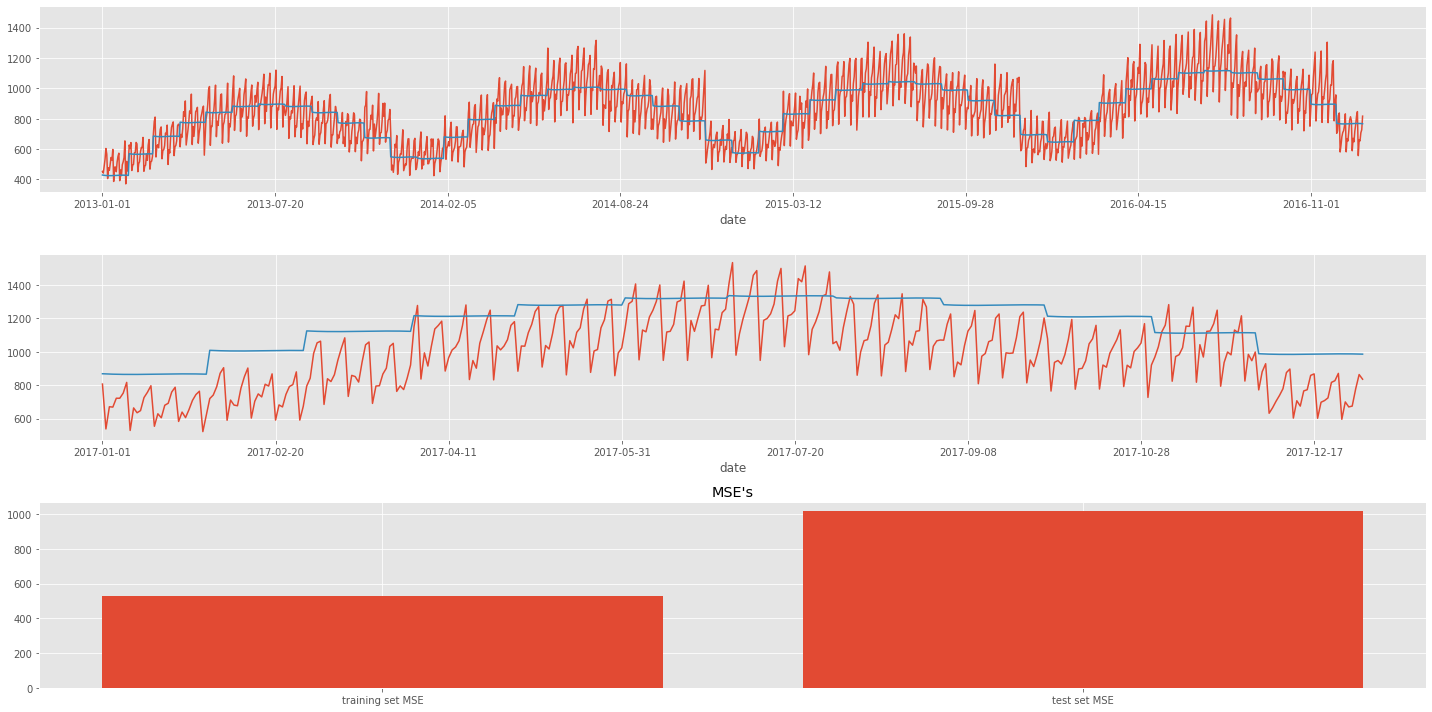

In [16]:
# plot the data
fig, axs = plt.subplots(3,1, figsize=(20,10))
train.groupby('date').sum()['sales'].plot(x='date', y='sales', ax=axs[0])
test.groupby('date').sum()['sales'].plot(x='date', y='sales', ax=axs[1])

## calculate predicted values for sales on train and test set
modelYtrain = w[0]
weight_idx = 1
for input in inputs:
  for i in np.arange(1, order+1):
    modelYtrain += w[weight_idx]*(train[input].values ** i)
    weight_idx += 1

modelYtest = w[0]
weight_idx = 1
for input in inputs:
  for i in np.arange(1, order+1):
    #print(f"input: {input} | order = {i} | weight: {w[weight_idx]}")
    modelYtest += w[weight_idx]*(test[input].values ** i)
    #print(f"values: {test[input].values ** i}")
    #print(f"modelYtest: {modelYtest}\n")
    weight_idx += 1

# plot model predictions over data
train[f'{order}-order model'] = modelYtrain; test[f'{order}-order model'] = modelYtest;
train.groupby('date').sum()[f'{order}-order model'].plot(x='date', y=f'{order}-order model', ax=axs[0])
test.groupby('date').sum()[f'{order}-order model'].plot(x='date', y=f'{order}-order model', ax=axs[1])

# plot MSE of model on train and test data
MSE_train = np.mean((train['sales'].values - modelYtrain)**2)
MSE_test = np.mean((test['sales'].values - modelYtest)**2)
axs[2].bar(['training set MSE', 'test set MSE'], [MSE_train, MSE_test])
axs[2].set_title("MSE's")
fig.tight_layout(); fig.show()
print(f"MSE_train: {MSE_train} | MSE_test: {MSE_test}")

### Straight linear regression performed okay but we notice 3 things about the data to make our model even more accurate.

1. The different stores have different sales numbers.
2. The sales increase roughly linearly over a period of a week.
3. The annual sales resemble a full sine period.

### 1. We account for the store differences by processing the categorical data into binary predictor data so a weight for each store can be calculated.

In [17]:
# add binary store data to train and test datasets to calculate weight from
for store in np.arange(1, num_stores + 1):
  train[f'store {store}'] = train['store'] == store
  test[f'store {store}'] = test['store'] == store

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

2. We account for the weekly linear sales period with a linear weight parameter for the week (we parsed the day of the week data earlier but just haven't used it until now).



3. We add in a sine function to our model with a period of 1 year.

Now our model is greatly simplified and will likely be even more accurate:

$predicted\_sales = w_0 + w_1*day\_of\_week + w_2*sin(day\_of\_year *\frac{\pi}{365})^2$

In [18]:
A = np.vstack((np.ones(len(train)), train['day_of_week'], (np.sin(train['day_of_year'] * np.pi / 365) ** 2))).T
w = np.linalg.lstsq(A, train['sales'], rcond=None)[0]
print(f"savvy model: {w[0]:0.2f} + {w[1]:0.2f}*day_of_week + {w[2]:0.2f}*sin(day_of_year*2*pi / 365) ^ 2")

savvy model: 49.86 + 5.23*day_of_week + 39.49*sin(day_of_year*2*pi / 365) ^ 2


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


MSE_train: 505.37257973988847 | MSE_test: 769.2404264098831


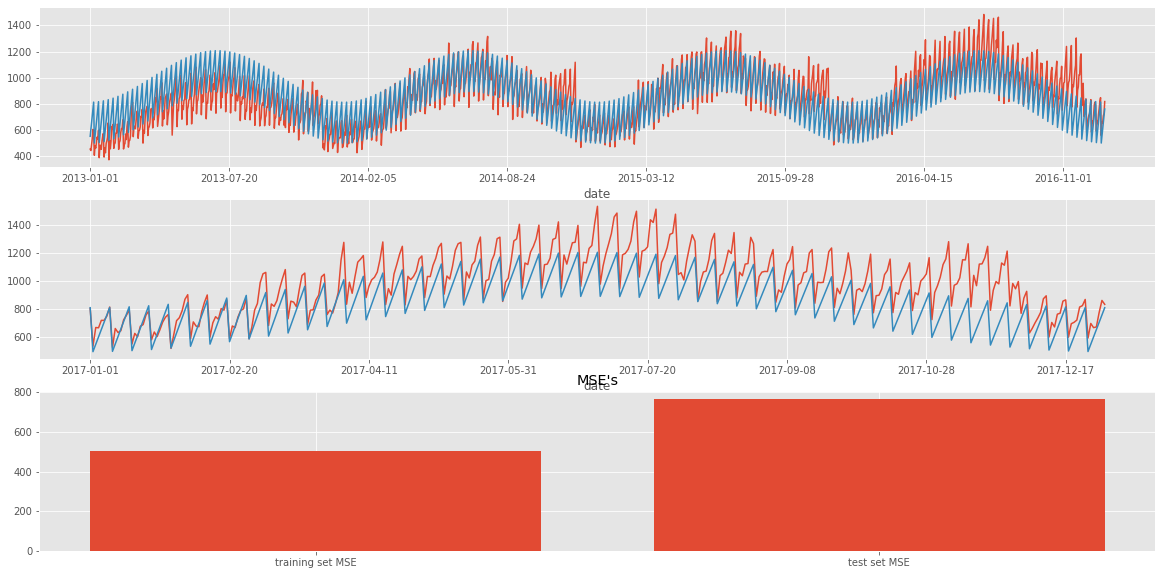

In [19]:
# plot the data
fig, axs = plt.subplots(3,1, figsize=(20,10))
train.groupby('date').sum()['sales'].plot(x='date', y='sales', ax=axs[0])
test.groupby('date').sum()['sales'].plot(x='date', y='sales', ax=axs[1])

## plot the model over data
#agg_train = train.groupby('date').sum(); agg_test = train.groupby('date').sum()
modelYtrain = w[0] + w[1]*train['day_of_week'].values + w[2]*(np.sin(train['day_of_year'] * np.pi / 365) ** 2)
modelYtest = w[0] + w[1]*test['day_of_week'].values + w[2]*(np.sin(test['day_of_year'] * np.pi / 365) ** 2)
train['savvy model'] = modelYtrain; test['savvy model'] = modelYtest;
train.groupby('date').sum()['savvy model'].plot(x='date', y='savvy model', ax=axs[0])
test.groupby('date').sum()['savvy model'].plot(x='date', y='savvy model', ax=axs[1])
#ax[0].plot(train['date'].unique().values, modelYtrain)
#ax[1].plot(test['date'].unique().values, modelYtest)

# plot MSE on train and test for model
MSE_train = np.mean((train['sales'].values - modelYtrain)**2)
MSE_test = np.mean((test['sales'].values - modelYtest)**2)
axs[2].bar(['training set MSE', 'test set MSE'], [MSE_train, MSE_test])
axs[2].set_title("MSE's")
fig.show()
print(f"MSE_train: {MSE_train} | MSE_test: {MSE_test}")